<a href="https://colab.research.google.com/github/joeneb24/Sales-Predictions/blob/main/SalesPredictionsMachineLearningPreprocessingAndRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Predictions Machine Learning

- Joseph Nebres

## Maching Learning - Preprocessing

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import set_config
from sklearn.linear_model import LinearRegression
set_config(display='diagram')

In [2]:
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics
def model_metrics(pipe, X_train, y_train, X_test, y_test, 
                       model_name='Regression Model', ):

  train_pred = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)
  
  metrics = ['train_MAE','test_MAE', 
             'train_RMSE', 'test_RMSE', 
             'train_R2', 'test_R2']
  
  train_mae = round(mean_absolute_error(y_train, train_pred),4)
  train_rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
  train_r2 = round(r2_score(y_train, train_pred),7)

  test_mae = round(mean_absolute_error(y_test, test_preds),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
  test_r2 = round(r2_score(y_test, test_preds),7)

  scores = pd.DataFrame(index=metrics, columns=[f'{model_name}_test'])
  scores.loc[metrics, f'{model_name}_test'] = [train_mae, test_mae,
                                               train_rmse, test_rmse,
                                               train_r2, test_r2]

  return scores

In [3]:
# Load in data
path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSxHc5Bn81Nol9OiDbN83XF95MeYhNwiwAMI5FM690GcXFOYExuKXRuScgH4YRyj7ugexrOSk43ZCJK/pub?gid=1198268787&single=true&output=csv'
df = pd.read_csv(path)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


At a quick glance, we see that the column Item_Identifier is not needed for machine learning. 

In [4]:
# Drop unneccessary columns for machine learning preprocessing, in this case the Item_Identifier won't help us for machine learning. 
df.drop('Item_Identifier', axis=1, inplace=True)
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
# Check for any duplicated data. 
df.duplicated().sum()

0

From looking at the head, we see that Item_Fat_Content has ordinal features, let's explore the different types of values. 

In [6]:
# Explore different types of values. 
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

We see that we need to replace the different types of values to make it an ordinal feature, we will use 0 for low fat and 1 for regular. 

In [7]:
# Replace regular and low fat variants to ordinal features. 
replacement_dictionary = {'Regular':1, 'reg':1, 'low fat':0, 'Low Fat':0, 'LF':0}
df['Item_Fat_Content'].replace(replacement_dictionary, inplace=True)
df['Item_Fat_Content']

0       0
1       1
2       0
3       1
4       0
       ..
8518    0
8519    1
8520    0
8521    1
8522    0
Name: Item_Fat_Content, Length: 8523, dtype: int64

From looking at the head, we see that Outlet_Size has ordinal features, let's explore the different types of values.

In [8]:
# Explore different types of values. 
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [9]:
# Replace regular and low fat variants to ordinal features. 
replacement_dictionary = {'High':2, 'Medium':1, 'Small':0}
df['Outlet_Size'].replace(replacement_dictionary, inplace=True)
df['Outlet_Size']

0       1.0
1       1.0
2       1.0
3       NaN
4       2.0
       ... 
8518    2.0
8519    NaN
8520    0.0
8521    1.0
8522    0.0
Name: Outlet_Size, Length: 8523, dtype: float64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   int64  
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                6113 non-null   float64
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 732.6+ KB


We see that Item_Fat_Content and Outlet_Size are changed to reflect they are ordinal features. Let's explore other data columns that are objects. 

In [11]:
# Explore different types of values. 
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

We see that these values are not repeats misspelled so we will not change anything here. 




In [12]:
# Explore different types of values. 
df['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

We see that these values are not repeats misspelled so we will not change anything here. 

In [13]:
df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

We need to handle the objects and missing values. 

In [14]:
# Explore different types of values. 
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

 The Outlet_Location_Type may be ordinal, but I do not know enough information on this, so I will treat it as a nominal. Plus the label has "Type". We will one hot encode this like the rest of the objects. 

In [15]:
# Explore different types of values. 
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

These values look normal for nominal objects, we will treat them as such. 

In [16]:
# Validation Split. 
# Split data to X and y, we are predicting Item_Outlet_Sales
X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
# Instantiate Column Selectors. 
# Creating a column list for only objects and only numbers
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [18]:
# Instantiate Transformers.
# Creating 3 types of transformers, with two different types of SimpleImputers. 
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [19]:
# Instantiate numeric pipeline. 
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [20]:
# Instantiate categorical pipeline. 
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [21]:
# Instantiate ColumnTransformer make_column_transformer. 
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
preprocessor = make_column_transformer(number_tuple, category_tuple, remainder = 'drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4253ec1df0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4253ec1b80>)])

# **Regression Models**

In [22]:
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics for a model
def eval_regression(y_true, y_pred, name='model'):
  """Takes true targets and predictions from a regression model and prints
  MAE, MSE, RMSE, AND R2 scores
  Set 'name' to name of model and 'train' or 'test' as appropriate"""
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  print(f'{name} Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

In [23]:
## Create an instance of the model
dummy = DummyRegressor(strategy='mean')

## Create a model pipeline
dummy_pipe = make_pipeline(preprocessor, dummy)

## Fit the model
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4253ec1df0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4253ec1b80>)])),
                ('dummyregressor', DummyRegressor())])

In [24]:
## Display model performance metrics using a function
train_preds = dummy_pipe.predict(X_train)
test_preds = dummy_pipe.predict(X_test)

eval_regression(y_train, train_preds, name='Baseline Regression Train')
eval_regression(y_test, test_preds, name='Baseline Regression Test')

Baseline Regression Train Scores
MAE: 1,360.2184 
MSE: 2,959,455.7045 
RMSE: 1,720.3069 
R2: 0.0000

Baseline Regression Test Scores
MAE: 1,326.1210 
MSE: 2,772,144.4627 
RMSE: 1,664.9758 
R2: -0.0048



### **Linear Regression Model**
- Instantiate the model.
- Create a model pipeline using the preprocessor and model.
- Fit the model pipeline on the X_train dataset. (Never fit on X_test.)


In [25]:
## Create an instance of the model
lin_reg = LinearRegression()

## Create a model pipeline
lin_reg_pipe = make_pipeline(preprocessor, lin_reg)

## Fit the model
lin_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4253ec1df0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4253ec1b80>)])),
                ('linearregression', LinearRegression())])

In [26]:
## Display model performance metrics using a function

train_preds = lin_reg_pipe.predict(X_train)
test_preds = lin_reg_pipe.predict(X_test)

eval_regression(y_train, train_preds, name='Linear Regression Train')
eval_regression(y_test, test_preds, name='Linear Regression Test')

Linear Regression Train Scores
MAE: 847.1288 
MSE: 1,297,558.1288 
RMSE: 1,139.1041 
R2: 0.5616

Linear Regression Test Scores
MAE: 804.1203 
MSE: 1,194,349.9312 
RMSE: 1,092.8632 
R2: 0.5671



## Linear Regression Model Observations

- The model above performed quite fair on the training data as well as the test data. We can see this based on a low R2 score for both the training scores and testing scores, at 0.5616 and 0.5671, respectively. 
- This model shows that the data may be a good fit for a linear regression model. We can say this because the training score on RMSE vs. the test scoreon RMSE were quite close. The difference in RMSE for the training and testing data shows that the predictions for Outlet Sales were only off by $47. 

## Random Forest Model 


In [27]:
## Create an instance of the model
ran_for = RandomForestRegressor(random_state = 42)

## Create a model pipeline
ran_for_pipe = make_pipeline(preprocessor, ran_for)

## Fit the model
ran_for_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4253ec1df0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4253ec1b80>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [28]:
## Display model performance metrics using a function
train_preds = ran_for_pipe.predict(X_train)
test_preds = ran_for_pipe.predict(X_test)

eval_regression(y_train, train_preds, name='Random Forest Train')
eval_regression(y_test, test_preds, name='Random Forest Test')

Random Forest Train Scores
MAE: 296.1609 
MSE: 182,273.3747 
RMSE: 426.9349 
R2: 0.9384

Random Forest Test Scores
MAE: 766.6650 
MSE: 1,217,531.7076 
RMSE: 1,103.4182 
R2: 0.5587



## Tuning Random Forest Model

In [34]:
#create a range of max_depth values
n_estimators = [50, 100, 200, 300, 400, 500, 600, 700, 800, 1000]

#create a dataframe to store train and test scores.
scores = pd.DataFrame(columns=['Train', 'Test'], index=n_estimators)

#loop over the values in depths
for n in n_estimators:
  #fit a new model with max_depth
  ran_for = RandomForestRegressor(random_state = 42, n_estimators=n)

  #put the model into a pipeline
  ran_for_pipe = make_pipeline(preprocessor, ran_for)
  
  #fit the model
  ran_for_pipe.fit(X_train, y_train)
  
  #create prediction arrays
  train_pred = ran_for_pipe.predict(X_train)
  test_pred = ran_for_pipe.predict(X_test)
  
  #evaluate the model using R2 Score
  train_r2score = r2_score(y_train, train_pred)
  test_r2score = r2_score(y_test, test_pred)
  
  #store the scores in the scores dataframe
  scores.loc[n, 'Train'] = train_r2score
  scores.loc[n, 'Test'] = test_r2score

In [35]:
scores

,Train,Test
50,0.935686,0.555033
100,0.93841,0.558702
200,0.939669,0.558484
300,0.940175,0.55881
400,0.940497,0.558881
500,0.940444,0.559279
600,0.94064,0.558912
700,0.940782,0.558843
800,0.940867,0.558294
1000,0.940856,0.558916


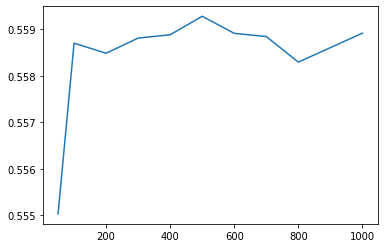

In [36]:
plt.plot(scores['Test'])

In [37]:
best_estimators = scores.sort_values(by='Test', ascending=False).index[0]
best_estimators

500

In [40]:
## Display model performance metrics using a function
best_rf = RandomForestRegressor(random_state = 42, n_estimators=best_estimators)

best_rf_pipe = make_pipeline(preprocessor, best_rf)

best_rf_pipe.fit(X_train, y_train)


eval_regression(y_train, best_rf_pipe.predict(X_train), name='Linear Regression Train')
eval_regression(y_test, best_rf_pipe.predict(X_test), name='Linear Regression Test')

Linear Regression Train Scores
MAE: 293.3091 
MSE: 176,253.5394 
RMSE: 419.8256 
R2: 0.9404

Linear Regression Test Scores
MAE: 767.5726 
MSE: 1,215,938.3653 
RMSE: 1,102.6960 
R2: 0.5593



## Random Forest Model Observations
- We see that even when we tune the random forest model useing n_estimators, the data did not improve much. We still see the similar problem of the Training R2 score and testing R2 score with a high variance. Again we can see this from the high R2 value for the training data and comparitively lower R2 value for the testing data. 
- This data also fails to predict the outlet sales by $683, as seen by the differences in the RMSE values from the two data splits. 

## Model Performance and Recommendations
- Overall, the best model is definitely the linear regression model. There were still some bias on the data, but compared to the high variance in the random forest model, it showed that it could better perform at predicting outlet sales. This is very apparent when comparing the differences in the training data's prediction outlet sales when comparing the RMSE. The linear regression model predicted the outlet sales within $47.

- As compared with the TUNED random forest model, the model was off by $683. 
- Becuase of these highlighted reason, I recommend the linear regression model over the random forest model in predicting outlet sales. 
